# Snippet Origin Analysis

## Table of Contents:
* [Read Exported Metadata DB](#read)
* [Classification](#classification)
* [General Statistics](#stats)
* [Visualization](#visualization)
* [Next Steps / Open Questions](#next_steps)

# Read Exported Metadata DB <a id="read"/>

In [1]:
import pandas as pd

bagfiles = pd.read_json('./bagfiles_vai_prod.json')
childbagfiles = pd.read_json('./childbagfiles_vai_prod.json')

childbagfiles['start_datetime'] = pd.to_datetime(childbagfiles.start, unit='ms')

In [2]:
joint_df = pd.merge(bagfiles, childbagfiles, left_on='guid',right_on='parent_guid',how='right',suffixes=('_parent','_child'))
joint_df.head()

_id_parent  \
0  {'$oid': '5ea194360275584c35e66a1b'}   
1  {'$oid': '5ea194360275584c35e66a1b'}   
2  {'$oid': '5ea194360275584c35e66a1b'}   
3  {'$oid': '5ea194360275584c35e66a1b'}   
4  {'$oid': '5ea194360275584c35e66a1b'}   

                                         link_parent  \
0  /mapr/059-va2.mbc.de/data/buffer/rd/athena/08_...   
1  /mapr/059-va2.mbc.de/data/buffer/rd/athena/08_...   
2  /mapr/059-va2.mbc.de/data/buffer/rd/athena/08_...   
3  /mapr/059-va2.mbc.de/data/buffer/rd/athena/08_...   
4  /mapr/059-va2.mbc.de/data/buffer/rd/athena/08_...   

                                        current_link  version_parent  \
0  /mapr/059-va2.mbc.de/data/buffer/rd/athena/08_...             0.1   
1  /mapr/059-va2.mbc.de/data/buffer/rd/athena/08_...             0.1   
2  /mapr/059-va2.mbc.de/data/buffer/rd/athena/08_...             0.1   
3  /mapr/059-va2.mbc.de/data/buffer/rd/athena/08_...             0.1   
4  /mapr/059-va2.mbc.de/data/buffer/rd/athena/08_...             0.1   

                                    file_name_parent file_type tags_parent  \
0  20200423_120901_CID_master_MGarage_SM_garage_t...  ORIGINAL      [test]   
1  20200423_120901_CID_master_MGarage_SM_garage_t...  ORIGINAL      [test]   
2  20200423_120901_CID_master_MGarage_SM_garage_t...  ORIGINAL      [test]   
3  20200423_120901_CID_master_MGarage_SM_garage_t...  ORIGINAL      [test]   
4  20200423_120901_CID_master_MGarage_SM_garage_t...  ORIGINAL      [test]   

  drive_types_parent processing_state  processing_priority  ...  \
0              [CID]       SUCCESSFUL                  0.0  ...   
1              [CID]       SUCCESSFUL                  0.0  ...   
2              [CID]       SUCCESSFUL                  0.0  ...   
3              [CID]       SUCCESSFUL                  0.0  ...   
4              [CID]       SUCCESSFUL                  0.0  ...   

                                        topics_child    size_child  \
0  [/LTP/control_trajectory, /LTP/planned_traject...  5.393822e+07   
1  [/cal/CalService/0/DsmInterface, /cal/CalServi...  3.445931e+08   
2  [/cal/CalService/0/DsmInterface, /cal/CalServi...  1.707310e+08   
3                                                 []  0.000000e+00   
4  [/cal/CalService/0/DsmInterface, /cal/CalServi...  1.239358e+09   

   num_messages_child  vehicle_id_num_child  tags_child  drive_types_child  \
0             20000.0             v222-5410      [test]              [CID]   
1             14021.0             v222-5410      [test]              [CID]   
2              6120.0             v222-5410      [test]              [CID]   
3                 0.0             v222-5410      [test]              [CID]   
4              8762.0             v222-5410      [test]              [CID]   

                             guid_child  origin_child  \
0  91c8f3e6-6fee-4b0b-99cf-a7be3f2aaf20            DE   
1  344c062d-b76b-4bb9-a6cc-2140ca49f3e1            DE   
2  a7ecf199-450e-4867-a055-a6f79238bae3            DE   
3  27a02389-467c-4947-b621-8e167630e7fd            DE   
4  7169ad85-f8c0-45b6-9f8f-362b2257ebfd            DE   

                                            metadata          start_datetime  
0                                                NaN 2020-04-23 10:09:04.856  
1                                                NaN 2020-04-23 10:09:02.397  
2                                                NaN 2020-04-23 10:09:04.856  
3  {'silent_testing_cv1': {'objects': [{'testcase... 1970-01-01 00:00:00.000  
4                                                NaN 2020-04-23 10:09:04.857  

[5 rows x 40 columns]

Dataframe joint_df contains parent bagfile information of all snippet in the same row. For some of the snippets, the parent bagfile is not found in the bagfile collection. The root cause of the missing parent bagfiles is a subject of another analysis, for the current analysis we are throwing these rows.

In [3]:
print(f'All snippets: {joint_df.shape[0]}')
snippets = joint_df[joint_df['guid_parent'].notna()]
print(f'Snippets with parent in DB: {snippets.shape[0]}')

parent_sum_tb = snippets.drop_duplicates(subset=["guid_parent"]).size_parent.sum() / 1e12
snippet_sum_tb = snippets.size_child.sum() / 1e12

print(f'\nOriginal files: {parent_sum_tb:.2f} TB')
print(f'Snippets with parent in DB: {snippet_sum_tb:.2f} TB ({snippet_sum_tb / parent_sum_tb:.1%})')


# Free memory
del bagfiles, childbagfiles, joint_df

All snippets: 72749
Snippets with parent in DB: 69633

Original files: 748.12 TB
Snippets with parent in DB: 658.99 TB (88.1%)


# Classification <a id="classification"/>

## Strips

In [4]:
strip_types = ['planning_io',
               'localization_and_map_creation_io',
              'fusion_io',
              'cid_bageval',
              'sem_io',
              'radar_input_eval']

for strip_type in strip_types:
    snippets.loc[snippets['file_name_child'].str.contains(strip_type, na=False), 'snippet_type'] = 'strip'
    snippets.loc[snippets['file_name_child'].str.contains(strip_type, na=False), 'specific_type'] = strip_type + ' (strip)'
    strip_type_sum_tb = snippets[snippets["specific_type"] == strip_type + ' (strip)'].size_child.sum()/1e12
    print(f'{strip_type}: {strip_type_sum_tb:.2f} TB')

planning_io: 53.41 TB
localization_and_map_creation_io: 65.02 TB
fusion_io: 41.32 TB
cid_bageval: 23.98 TB
sem_io: 0.16 TB
radar_input_eval: 1.56 TB


## Splits

### Based on file name

In [5]:
split_types = ["disengagement",
    "fallback",
    "logbook",
    "silent_testing_cv1",
    "gps",
    "stereo_cnn",
    "silent_testing_lidar",
    "silent_testing_traffic_lights",
    "annotation"]

for split_type in split_types:
    snippets.loc[snippets['file_name_child'].str.contains(split_type, na=False), 'snippet_type'] = 'split'
    snippets.loc[snippets['file_name_child'].str.contains(split_type, na=False), 'specific_type'] = split_type + ' (split)'

### Based on metadata information

In [6]:
snippet_metadata = snippets["metadata"].apply(pd.Series)

In [7]:
print('Split_type - {newly_found}/{found}\n')

found_by_name = snippets[snippets.snippet_type == 'split'].shape[0]
found_by_metadata = 0

for split_type in split_types:
    if split_type not in snippet_metadata.keys():
        print(f'{split_type} - 0 / 0')
        continue
    found_by_metadata += snippets.loc[snippet_metadata[split_type].notna() & snippets.specific_type.isna()].shape[0]
    print(f'{split_type} - {snippets.loc[snippet_metadata[split_type].notna() & snippets.specific_type.isna()].shape[0]} / {snippets.loc[snippet_metadata[split_type].notna()].shape[0]}')
    snippets.loc[snippet_metadata[split_type].notna() & snippets.specific_type.isna(), 'snippet_type'] = 'split'
    snippets.loc[snippet_metadata[split_type].notna() & snippets.specific_type.isna(), 'specific_type'] = split_type + ' (split)'

print(f'\nSplits found based on file name: {found_by_name}')
print(f'Splits found based on metadata: {found_by_metadata}')
print(f'\nStill missing (splits or strips): {snippets[snippets.specific_type.isna()].shape[0]}')

Split_type - {newly_found}/{found}

disengagement - 330 / 7718
fallback - 0 / 13205
logbook - 3615 / 3616
silent_testing_cv1 - 0 / 8372
gps - 0 / 0
stereo_cnn - 0 / 0
silent_testing_lidar - 0 / 0
silent_testing_traffic_lights - 0 / 0
annotation - 0 / 490

Splits found based on file name: 43577
Splits found based on metadata: 3945

Still missing (splits or strips): 5819


# General Statistics <a id="stats"/>

In [8]:
snippet_type_stats = snippets.fillna(-1).groupby('snippet_type').agg({'size_child': ['sum','count']})["size_child"]
snippet_type_stats["sum"] = snippet_type_stats["sum"].div(1e12)
snippet_type_stats["sum_percent"] = snippet_type_stats["sum"].div(snippet_type_stats["sum"].sum() / 100)
print(snippet_type_stats.sort_values(by=['sum'], ascending=False))

                     sum  count  sum_percent
snippet_type                                
split         416.634477  47522    63.223144
strip         184.337776  16292    27.972754
-1             58.018196   5819     8.804103


In [9]:
specific_type_stats = snippets.fillna(-1).groupby('specific_type').agg({'size_child': ['sum','count']})["size_child"]
specific_type_stats["sum"] = specific_type_stats["sum"].div(1e12)
specific_type_stats["sum_percent"] = specific_type_stats["sum"].div(specific_type_stats["sum"].sum() / 100)
print(specific_type_stats.sort_values(by=['sum'], ascending=False))

                                                 sum  count  sum_percent
specific_type                                                           
fallback (split)                          197.429034  17894    29.959316
logbook (split)                            79.534827   3615    12.069193
disengagement (split)                      76.835001   7697    11.659501
localization_and_map_creation_io (strip)   64.654952   2947     9.811212
-1                                         58.018196   5819     8.804103
silent_testing_cv1 (split)                 54.019141  17644     8.197257
planning_io (strip)                        53.027084   2936     8.046715
fusion_io (strip)                          41.042441   2954     6.228078
cid_bageval (strip)                        23.897239   2966     3.626341
annotation (split)                          8.816473    672     1.337876
radar_input_eval (strip)                    1.552513   1516     0.235590
sem_io (strip)                              0.16354

# Visualizing Snippets Over Time <a id="visualization"/>

In [10]:
snippets.index = snippets.start_datetime

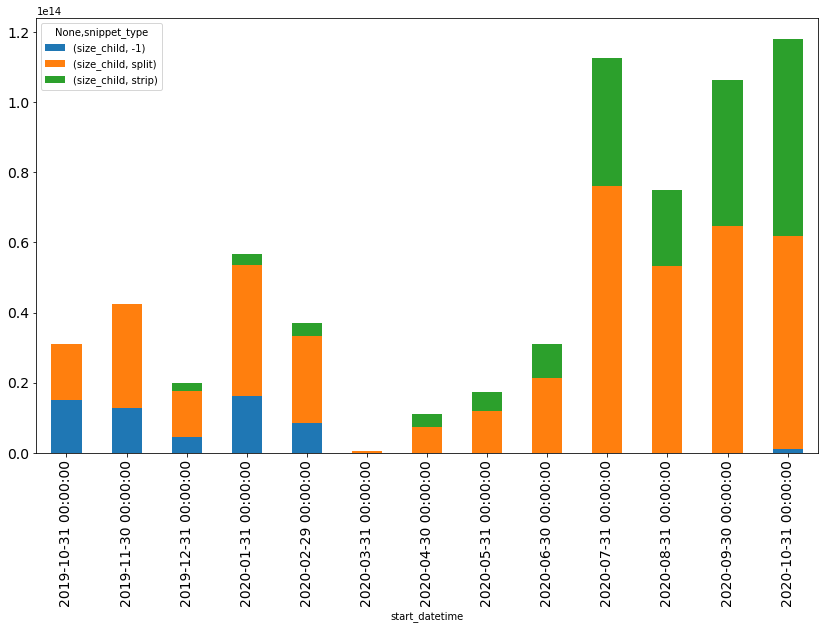

In [11]:
snippet_type_size_by_month = snippets.fillna(-1)[snippets.start_child!=0][["start_datetime","snippet_type","size_child","specific_type"]].groupby([pd.Grouper(freq='M'), 'snippet_type']).sum()
snippet_type_fig = snippet_type_size_by_month.unstack().plot(kind='bar', stacked=True, figsize=(14, 8), fontsize=14)
snippet_type_fig.figure.savefig('snippet_type_fig.pdf')

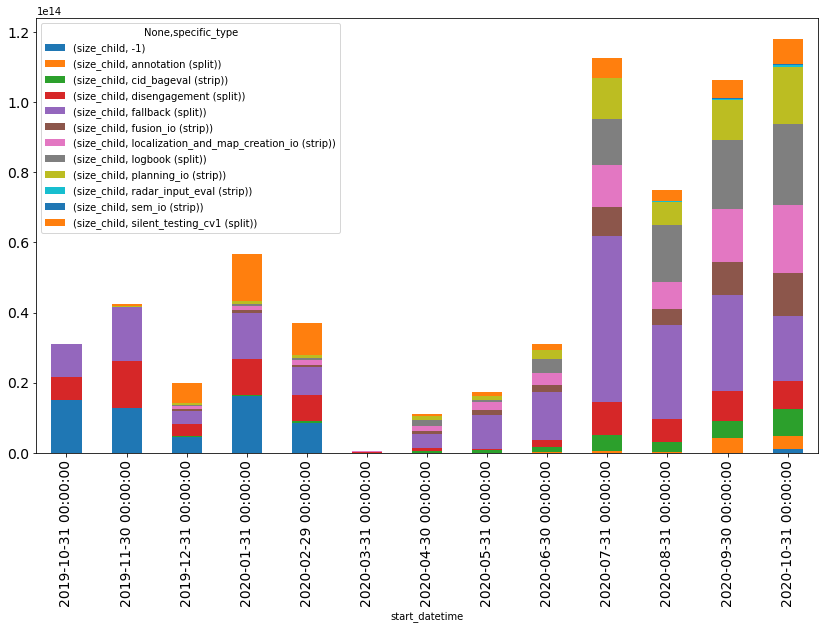

In [12]:
specific_type_size_by_month = snippets.fillna(-1)[snippets.start_child!=0][["start_datetime","snippet_type","size_child","specific_type"]].groupby([pd.Grouper(freq='M'), 'specific_type']).sum()
specific_type_fig = specific_type_size_by_month.unstack().plot(kind='bar',stacked=True,  figsize=(14, 8), fontsize=14)
specific_type_fig.figure.savefig('specific_type_fig.pdf')

## Strips Only

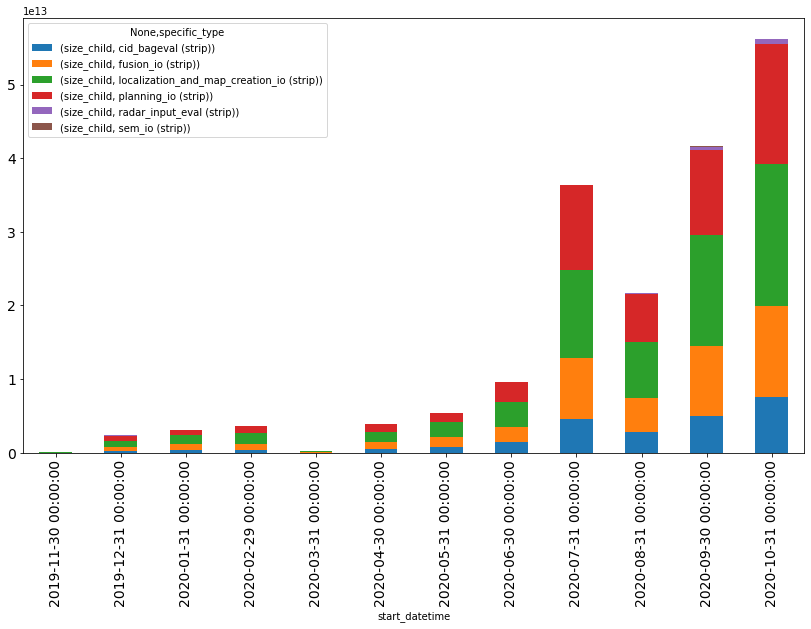

In [13]:
specific_strip_type_size_by_month = snippets.fillna(-1)[(snippets.start_child!=0) & (snippets.snippet_type == 'strip')][["start_datetime","snippet_type","size_child","specific_type"]].groupby([pd.Grouper(freq='M'), 'specific_type']).sum()
specific_strip_type_fig = specific_strip_type_size_by_month.unstack().plot(kind='bar',stacked=True,  figsize=(14, 8), fontsize=14)
specific_strip_type_fig.figure.savefig('specific_strip_type_fig.pdf')

## Splits only

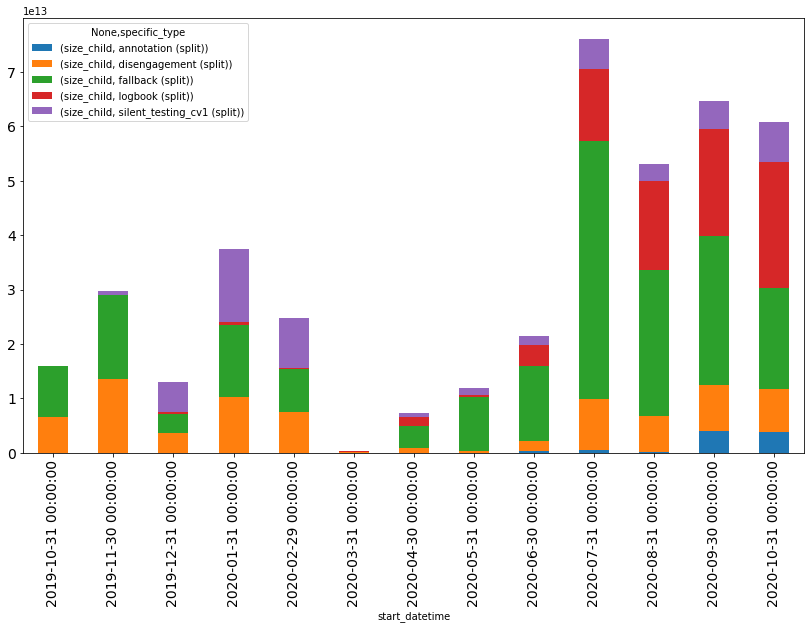

In [14]:
specific_split_type_size_by_month = snippets.fillna(-1)[(snippets.start_child!=0) & (snippets.snippet_type == 'split')][["start_datetime","snippet_type","size_child","specific_type"]].groupby([pd.Grouper(freq='M'), 'specific_type']).sum()
specific_split_type_fig = specific_split_type_size_by_month.unstack().plot(kind='bar',stacked=True,  figsize=(14, 8), fontsize=14)
specific_split_type_fig.figure.savefig('specific_split_type_fig.pdf')

## Next Steps / Open Questions <a id="next_steps"/>

#### Unclassified files

Possible ideas (see investigation below):
- ~~test files~~ (snippet with tag [test]: 3529 classified, 60 unclassified)
- Deeper investigation of specific type with 0 classified snippets
 - gps
 - stereo_cnn
 - silent_testing_lidar
 - silent_testing_traffic_lights
 
#### Improve Visualization

- Change Library (Plotly)
- Fix scale
- Grouped bars vs stacked bars

#### Generate Report Automatically (MongoDB Aggregation Pipeline?)

#### Investigate Storage Allocation on Different Clusters

#### Investigate data consistency

Possible topics:
- orphan snippets
- consistency with file catalog
- snippets not in our metadata DB
- unclassified snippets
- merge childbagfiles to bagfiles (add / link extractor_id / extractor_request) ?

In [15]:
has_test_tag_mask = snippets.tags_child.apply(lambda x: 'test' in x if hasattr(x, '__iter__') else False)

print(f'Snippets with a tag "test":')
print(f'{snippets[has_test_tag_mask & snippets.snippet_type.notna()].shape[0]} classified')
print(f'{snippets[has_test_tag_mask & snippets.snippet_type.isna()].shape[0]} unclassified')

Snippets with a tag "test":
3880 classified
26 unclassified


In [16]:
print(f'Snippet types with no classified snippets:')
all_specific_types = split_types + strip_types
for specific_type in all_specific_types:
    if (specific_type in split_types) & (snippets[snippets.specific_type == specific_type + " (split)"].shape[0] == 0):
        print(f'- {specific_type} (split)')
    elif (specific_type in strip_types) & (snippets[snippets.specific_type == specific_type + " (strip)"].shape[0] == 0):
        print(f'- {specific_type} (strip)')

Snippet types with no classified snippets:
- gps (split)
- stereo_cnn (split)
- silent_testing_lidar (split)
- silent_testing_traffic_lights (split)
